In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from copy import deepcopy

In [2]:
class leastSquaresGD:
    def __init__(self, error):
        self.x_original = None  
        self.a_original = None
        self.b_original = None
        self.x = None      # weights
        self.a = None      # xTrain
        self.b = None
        self.initialTime = None
        self.error = error
        self.grad = None  
        self.norm = None
        self.lam = None
        self.gr = None    # gr_list
        self.theta = None
        self.vanPlt = None
        self.AdapPlt = None
        self.LSPlt = None
        self.BazPlt = None
        self.Max = 0

    def generate(self, function, dim, vec_len, scale):
        for i in range(dim):
            globals()['X'+str(i)] = [0]*vec_len
        for j in range(vec_len):
            globals()['X'+str(0)][j] = (random.random()+1e-12)*scale
            y = function(globals()['X'+str(0)][j])
            noiz = 3
            for k in range(dim):
                globals()['X'+str(k)][j] = y + np.random.normal(0,noiz)
                noiz += 3
        A = np.array([globals()['X'+str(i)] for i in range(dim)]).T
        self.a_original = A
        self.x_original = np.random.rand(len(A[0]))*scale
        self.b_original = A @ self.x_original + np.random.normal(0,3,(A @ self.x_original).shape)
        
    def f(self, X):
        return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
    def g(self, X):
        return self.a.T @ (self.a @ X - self.b)
    def Step(self):
        self.x = self.x - self.lam*self.grad
    
    def normal(self, X): 
        return np.linalg.norm(X)
    
    def Vanilla(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        L = np.max( np.linalg.svd( self.a @ self.a.T ) [1] )
        self.lam = 1/L
        self.grad = self.g(self.x)
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            self.Step()
            self.grad = self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
        print(' \n Vanilla Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(len(self.gr),600) , 'g', self.vanPlt, 'Vanilla') # replaced len(self.gr) with 600
        self.PrintResults()
    
    def Adaptive(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.lam = random.random()+1e-12
        self.theta = float(random.getrandbits(128))
        oldX = deepcopy(self.x)
        self.grad = self.g(self.x)
        self.Step()
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            oldLam = deepcopy(self.lam)
            min1 = np.sqrt(1 + self.theta)*self.lam
            min2 = ( np.linalg.norm( self.x - oldX ) ) \
                / ( 2 * np.linalg.norm(self.g(self.x) - self.g(oldX) ) )
            self.lam = np.min([min1,min2])
            oldX = deepcopy(self.x)
            self.Step() # update x
            self.theta = self.lam/oldLam
            self.grad = self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
        print('\n Adaptive Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(len(self.gr),600) , 'y', self.AdapPlt, 'Adaptive')
        self.PrintResults()
    
    def BackTrack(self):
        rho = random.random()
        lam = random.randrange(1e6)
        while lam > ( self.normal( lam * self.grad ) / \
                     ( self.normal( self.g( self.x - lam * self.grad ) - self.grad ) )  ):
            lam = rho * lam
        self.lam = lam

    def LineSearch(self):
        self.initialTime = time.time()
#         self.lam_list = []
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.grad = self.g(self.x)
        self.norm = self.normal(self.grad)
        self.BackTrack()
        while self.norm > self.error:
            self.Step()
            self.grad =  self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
            self.BackTrack()
        print('\n Line Search Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(len(self.gr),600) , 'b', self.LSPlt, 'LineSearch')
        self.PrintResults()
    
    def Barzilai(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.grad = self.g(self.x)
        self.lam = random.random()+1e-12
        oldX = deepcopy(self.x)
        self.Step()
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            oldLam = deepcopy(self.lam)
            self.lam = np.dot( self.x - oldX, self.g(self.x) - self.g(oldX) ) \
                        / np.linalg.norm(self.g(self.x) - self.g(oldX))**2
            oldX = deepcopy(self.x)
            self.Step()
            self.grad = self.g(self.x)
            self.norm =  self.normal(self.grad)
            self.gr.append( self.norm)
        print('\n Barzilai-Borwein Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(len(self.gr),600) , 'r', self.BazPlt, 'Barzilai')
        self.PrintResults()
    
    def SetPlots(self, Min, Max, colour, name, label):
        name = plt.plot( range( Min, Max ) , self.gr[Min:Max] , c = colour , label = label)
    def PrintPlots(self):
        self.vanPlt
        self.AdapPlt
        self.LSPlt
        self.BazPlt
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc='best')
        plt.title(label = 'Norm of Gradient in domain [{}, {}]'.format(0,self.Max) )
        plt.show()
    def PrintResults(self):
        print('At final iteration k =', len(self.gr), ':')
        print('x vector is:', self.x)
        print('Gradient Norm is:', self.norm)
        print('Time taken:', time.time() - self.initialTime)
        print('Final Lambda value: ', self.lam)

In [5]:
def linFunc(x):
    return 2*x + 5

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 41808 :
x vector is: [0.53548869 0.29372287 0.75032239 0.47533558 0.8958602  0.48388013
 0.528366   0.72016429 0.22419198 0.31103784]
Gradient Norm is: 9.996748030639058e-07
Time taken: 0.7672867774963379
Final Lambda value:  2.735101195518827e-07

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 6673 :
x vector is: [0.53548869 0.29372287 0.75032239 0.47533558 0.8958602  0.48388013
 0.528366   0.72016429 0.22419198 0.31103784]
Gradient Norm is: 9.938592875013426e-07
Time taken: 34.75869107246399
Final Lambda value:  1.64484122600821e-05

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 16261 :
x vector is: [0.5354887  0.29372287 0.75032239 0.47533558 0.8958602  0.48388013
 0.528366   0.72016429 0.22419198 0.31103784]
Gradient Norm is: 9.975894498496208e-07
Time taken: 1.2053658962249756
Final

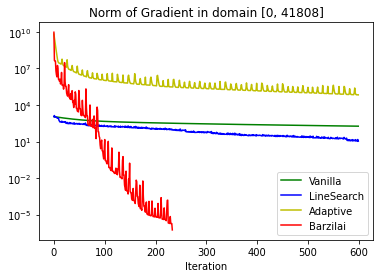

In [6]:
G = leastSquaresGD(1e-6)
G.generate(linFunc,10,100, 1)
G.Vanilla()
G.LineSearch()
G.Adaptive()
G.Barzilai()
G.PrintPlots()